# Image Processing


## Reading and plotting images

Julia provides a large set of image processing functions in the `Images` package. However, here we will focus on the mathematics and the algorithm behind some of these functions, and work directly on the arrays.

We will use `PyPlot` to read and plot images, as shown below:

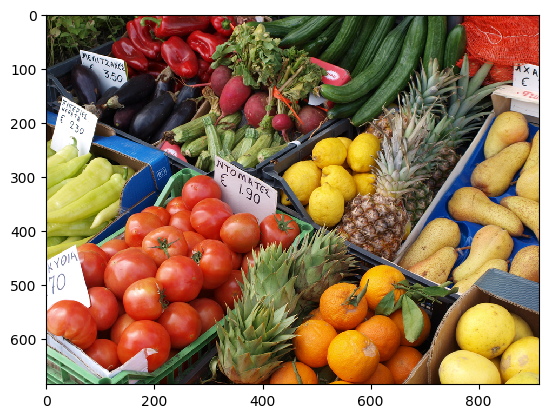

In [1]:
using PyPlot
A = imread("sample_photo.png")
imshow(A);

Using standard Julia functions, we can determine that the image is represented in a 3-dimensional array of `Float32`, with values between 0 and 1:

In [2]:
println("A is of type $(typeof(A)) with dimensions $(size(A))")
println("The values of A range between $(minimum(A)) and $(maximum(A))")

A is of type Array{Float32,3} with dimensions (684, 912, 3)
The values of A range between 0.0 and 1.0


Here, the first 2 dimensions are row and the column indices of the pixels in the image, and the 3rd dimension of length 3 correspond to the RGB (Red-Green-Blue) components of the corresponding color.

It is convenient to work with `Float` numbers, however, images are normally stored as `UInt8` with only 256 integer values for each RGB components. This is also supported by PyPlot, but for simplicity we will use the `Float32` format here.

### RGB values, Grayscale images

To illustrate how the RGB components build up the color of each pixel, we can build and plot new images which only contain each of the components:

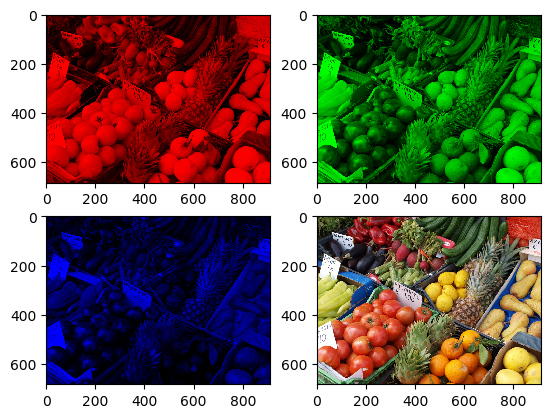

In [3]:
Ar = copy(A); Ar[:,:,[2,3]] .= 0.0;
Ag = copy(A); Ag[:,:,[1,3]] .= 0.0;
Ab = copy(A); Ab[:,:,[1,2]] .= 0.0;
subplot(2,2,1); imshow(Ar);
subplot(2,2,2); imshow(Ag);
subplot(2,2,3); imshow(Ab);
subplot(2,2,4); imshow(A);

The image algorithms we will cover here are easiest understood by considering a single component instead of the full RGB color (such as the *intensity* or the *brightness* of each pixel). Here we simply find the average of each color component, and treat the resulting array as a grayscale image:

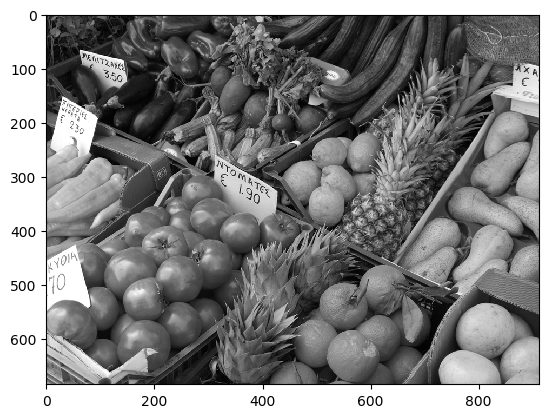

In [4]:
using Statistics
B = mean(A, dims=3)[:,:,1]

function imshow_scale(A)
    # Like imshow(A) but scales the values to [0,1] and supports grayscale
    
    A .-= minimum(A)            # Scale and shift to [0,1]
    A ./= maximum(A)
    if ndims(A) < 3
        A = reshape(A, size(A,1), size(A,2), 1)
    end
    if size(A,3) == 1
        A = repeat(A, 1, 1, 3)  # Set R=G=B for grayscale
    end
    imshow(A)
end

imshow_scale(B);

We will also sometimes consider *binary images*, which only contains two colors for example black and white. One way to generate these is by applying a threshold on an image. Below we also show how to *invert* an image, by applying the transformation $1-x$ to each gray value $x$.

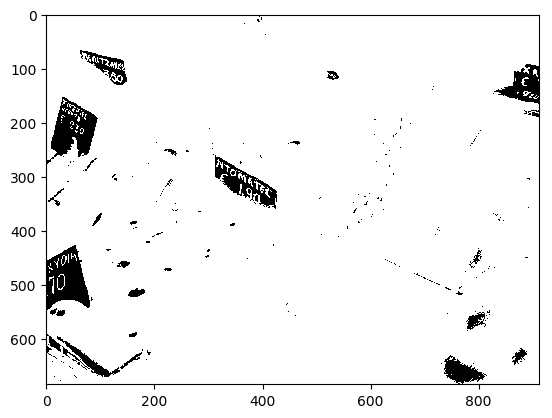

In [5]:
function image_threshold(A, th)
    return Float64.(A .> th)
end

imshow_scale(1.0 .- image_threshold(B, 0.8));

## Image scaling

One imporatant image operation is *scaling*, that is, change the number of pixels along each direction of the image. First consider the so-called *downsampling* of an image by a factor of 2. While we could simply extract every second pixel in each row and each column, a slightly better option is to average the values in each 2-by-2 block:

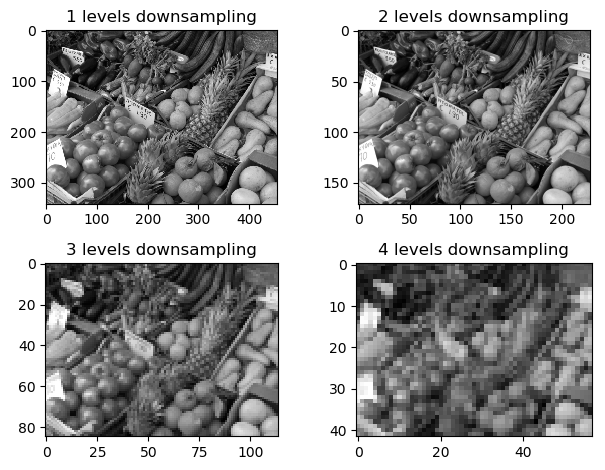

In [6]:
function image_downsample(A)
    # For simplicity, ignore last row/column if size is odd
    sz = size(A)
    sz2 = sz .÷ 2
    B = (A[1:2:2sz2[1], 1:2:2sz2[2], :] .+
         A[2:2:2sz2[1], 1:2:2sz2[2], :] .+
         A[1:2:2sz2[1], 2:2:2sz2[2], :] .+
         A[2:2:2sz2[1], 2:2:2sz2[2], :]) ./ 4
end

C = copy(B);
for i = 1:4
    C = image_downsample(C);
    subplot(2,2,i), imshow_scale(C)
    title("$(i) levels downsampling")
end
tight_layout()

*Upscaling* an image, that is, increasing its size, is a more difficult operation. Is is obviously impossible to know the intensity of the added pixels, but assuming the variations are small one can for example interpolate between the given values. One simple interpolation is *bilinear*, which for a factor of 2 simply becomes averaging between neighboring pixel values:

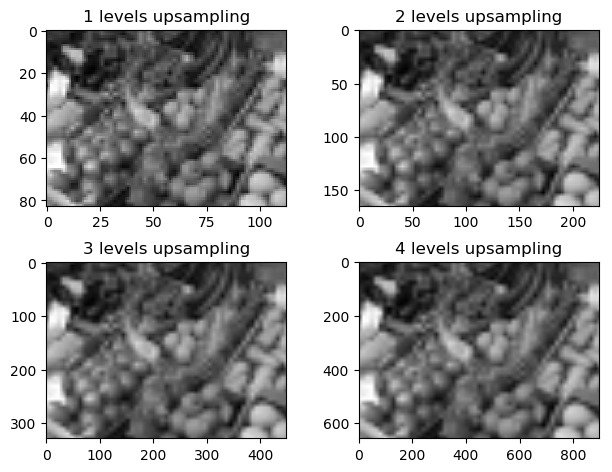

In [7]:
function image_upsample(A)
    sz = size(A)
    B = zeros(Float32, 2sz[1]-1, 2sz[2]-1, sz[3])
    B[1:2:end, 1:2:end, :] .= A
    B[2:2:end-1, 1:2:end, :] .= (A[1:end-1,:,:] .+ A[2:end,:,:]) ./ 2
    B[1:2:end, 2:2:end-1, :] .= (A[:,1:end-1,:] .+ A[:,2:end,:]) ./ 2
    B[2:2:end-1, 2:2:end-1, :] .= (A[1:end-1,1:end-1,:] .+ A[1:end-1,2:end,:]
                               .+  A[2:end,1:end-1,:] .+ A[2:end,2:end,:]) ./ 4
    return B
end

D = copy(C);
for i = 1:4
    D = image_upsample(D);
    subplot(2,2,i), imshow_scale(D)
    title("$(i) levels upsampling")
end
tight_layout()

The resulting image is of course much less detailed that the original, but that was expected since we reduced its size by a factor of $2^4=16$ in each direction:

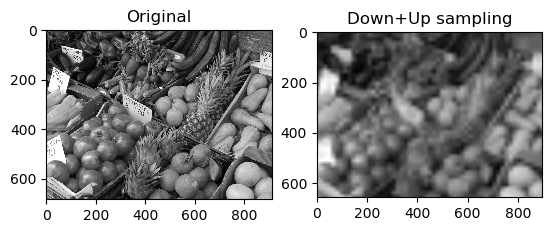

In [8]:
subplot(1,2,1); imshow_scale(B); title("Original");
subplot(1,2,2); imshow_scale(D); title("Down+Up sampling");

## Filtering

In *spatial filtering* of an image, we apply a given function to the gray valeues in a neighborhood of each pixel. A simple example is a function which takes the average of the 3-by-3 mask obtained by considering a pixel and its immediate neighbors:

In [9]:
function image_avgfilter(A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        B[i,j] = mean(A[i-1:i+1, j-1:j+1])
    end
    return B
end

image_avgfilter (generic function with 1 method)

### Smoothing

If we apply the average filter several times, and zoom in a portion of the image, we can see that it has the effect of *smoothing*, or *blurring*, the image:

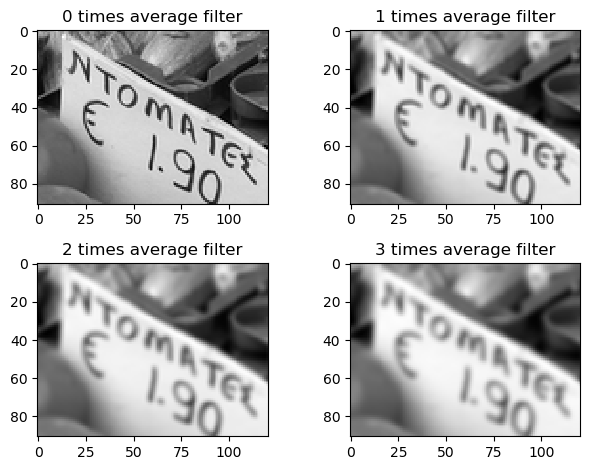

In [10]:
function filter_demo(B, filter_function)
    E = copy(B);
    for i = 0:3
        subplot(2,2,i+1); imshow_scale(E[260:350,300:420,:])
        title("$(i) times average filter")
        E = filter_function(E);
    end
    tight_layout()
end
filter_demo(B, image_avgfilter)

However, the average filter also tends to reduce certain types of noise, demonstrated below by adding normal distributed random numbers to the image:

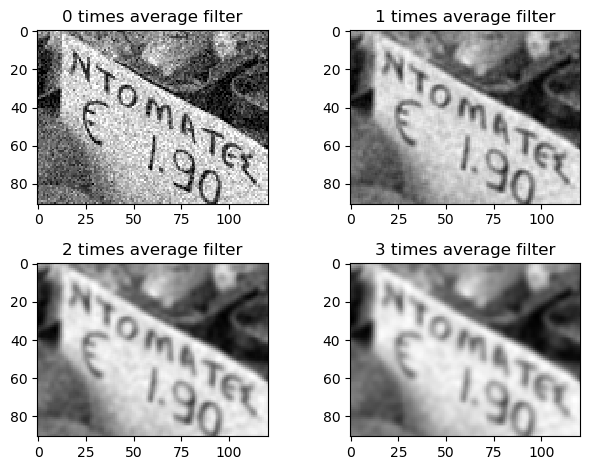

In [11]:
Bnoise = B + 0.1randn(size(B))   # Add noise
Bnoise = max.(min.(Bnoise, 1.0), 0.0) # Ensure values in [0,1]
filter_demo(Bnoise, image_avgfilter)

### Median filtering

A slight variation of the average filter is the *median filter*, which sets a pixel to the median of the gray values in the 3-by-3 neighboring mask:

In [12]:
function image_medianfilter(A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        B[i,j] = median(A[i-1:i+1, j-1:j+1])
    end
    return B
end

image_medianfilter (generic function with 1 method)

The median filter is particularly good at removing noise that only affects a small number of pixels, which we model below by randomly changing only some of the pixels in the image:

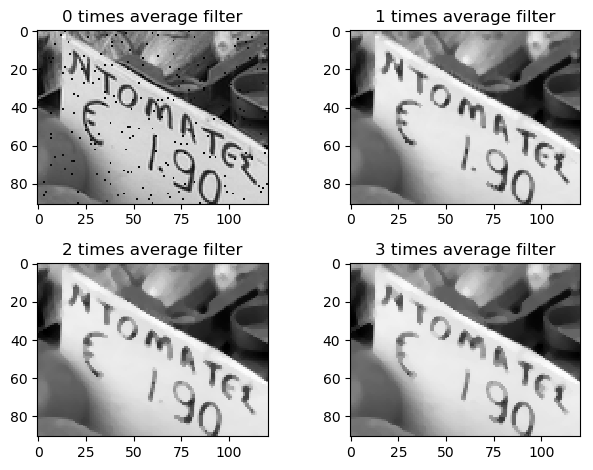

In [13]:
Bnoise2 = copy(B)
Bnoise2[rand(1:length(B), 10000)] = 0.1rand(10000)
filter_demo(Bnoise2, image_medianfilter)

### Edge detection

The previous filters tend to smooth or blur out noise and other sharp features in the image. Next we will do the opposite, and try to *detect* a sharp variation in gray values between neighboring pixels. This can be used to find the edges between regions in the image.

We will detect large changes using centered gradient approximations, that is:

$$
\nabla A_{ij} \approx
\begin{pmatrix}
A_{i+1,j} - A_{i-1,j} \\
A_{i,j+1} - A_{i,j-1} \\
\end{pmatrix}
$$

Clearly one of these components will be either large positive or large negative if there is a big jump between neighboring values, so our filter will compute the maximum of the absolute values of the gradient:

In [14]:
function image_maxabsgradfilter(A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        a = A[i-1:i+1, j-1:j+1]
        B[i,j] = max(abs(a[3,2] - a[1,2]), abs(a[2,3] - a[2,1]))
    end
    return B
end

image_maxabsgradfilter (generic function with 1 method)

To improve the edge detection, we first smooth the image using the average filter before applying the gradient filter:

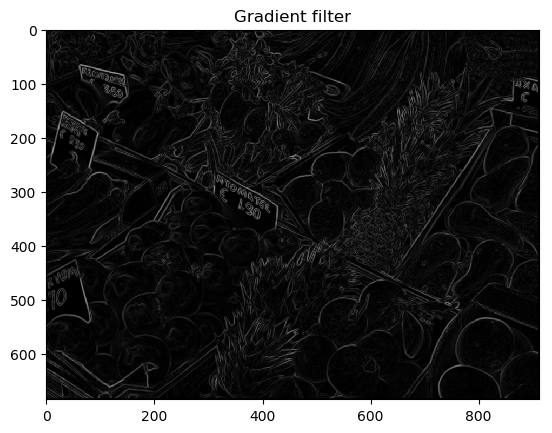

In [15]:
Bsmooth = image_avgfilter(B);
Bgrad = image_maxabsgradfilter(Bsmooth);
imshow_scale(Bgrad); title("Gradient filter");

Finally, we can threshold and invert the image to find the edges:

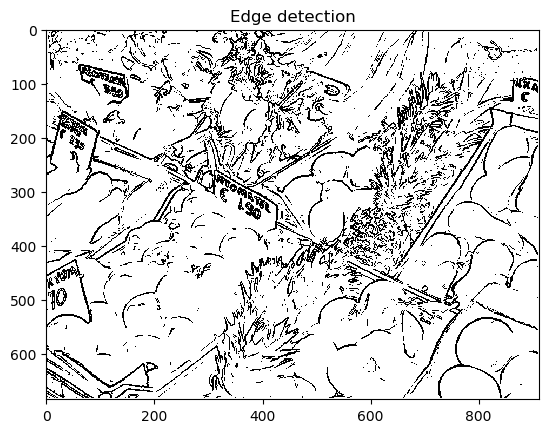

In [16]:
Bedges = 1.0 .- image_threshold(Bgrad, 0.1)
imshow_scale(Bedges); title("Edge detection");

## The Fourier Transform

The 2D discrete Fourier Transform decomposes a 2D array into a sum of complex exponentials:

$$
f(x,y) = \frac{1}{mn} \sum_{u=0}^{m-1} \sum_{v=0}^{n-1} F(u,v)
  \exp \left[2\pi i \left(\frac{xu}{m} + \frac{yv}{n}\right) \right]
$$

where the *Fourier coefficients* are defined by

$$
F(u,v) = \sum_{x=0}^{m-1} \sum_{y=0}^{n-1} f(x,y)
  \exp \left[-2\pi i \left(\frac{xu}{m} + \frac{yv}{n}\right) \right]
$$

They are useful in image processing for performing fast filtering, compression, detection of periodic features, etc.

First let us plot the Fourier coefficients of some simple images:

In [17]:
using FFTW

function imagefft_demo(A)
    AF = fftshift(fft(A))
    subplot(1,2,1); imshow_scale(A);
    subplot(1,2,2); imshow_scale(log.(1 .+ abs.(AF)));
    return
end

imagefft_demo (generic function with 1 method)

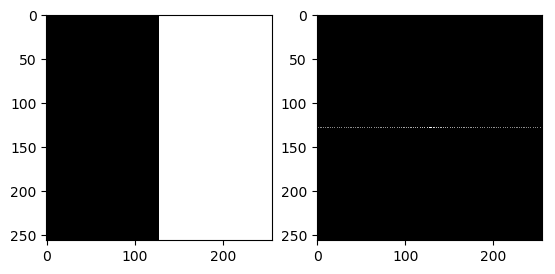

In [18]:
G = [zeros(256,128) ones(256,128)]
imagefft_demo(G)

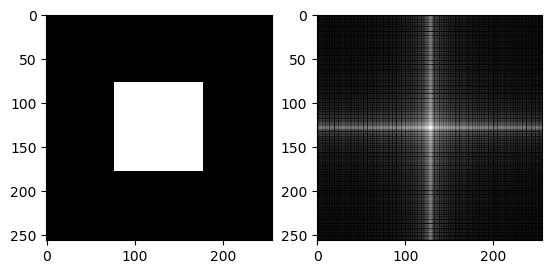

In [19]:
G = zeros(256, 256)
G[78:178, 78:178] .= 1.0
imagefft_demo(G)

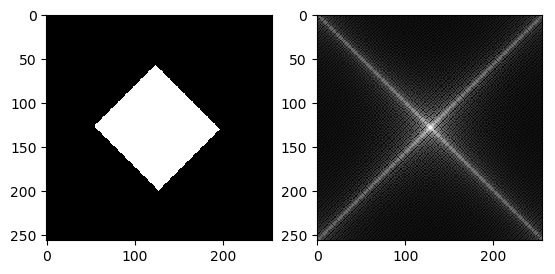

In [20]:
G = Float32[ (i+j<329) && (i+j>182) && (i-j>-67) && (i-j<73) for i = 1:256, j = 1:256 ]
imagefft_demo(G)

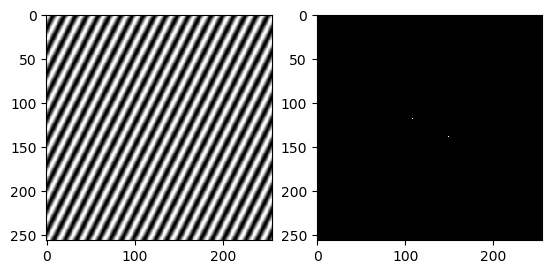

In [21]:
G = Float32[ sin(2pi*(10i + 20j)/256) for i = 1:256, j = 1:256 ]
imagefft_demo(G)

Many of these patterns can be understood from the underlying Fourier expansion. However, for a general image the pattern of the Fourier spectrum is less clear. We would expect the coefficients from a relatively smooth image to decay away from the center though:

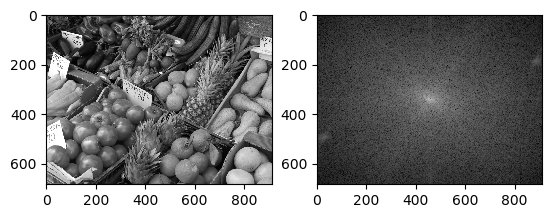

In [22]:
imagefft_demo(B)

### Removing periodic noise

One application of image processing using the Fourier transform is to remove periodic noise. Below we demonstrate this using a made-up example with a given frequency and direction of the noise, but it can be made more general.

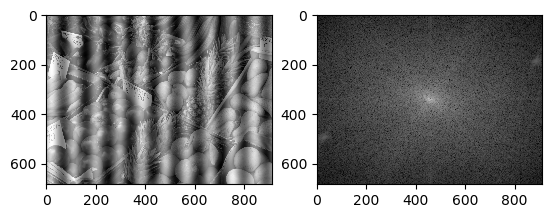

In [23]:
Bpernoise = copy(B)
Bpernoise = B + 0.5*Float32[sin(2π*10j / size(B,2)) for i = 1:size(B,1), j = 1:size(B,2) ]
imagefft_demo(Bpernoise)

Now compute the Fourier transform, and set the (known) noise frequencies to zero:

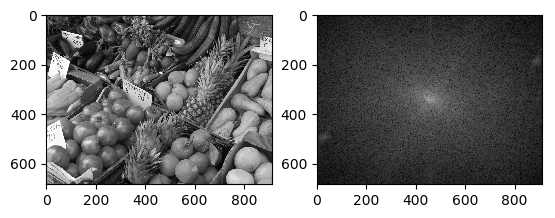

In [24]:
# Filter
BF = fftshift(fft(Bpernoise))
mid = size(B) .÷ 2 .+ 1
BF[mid[1], mid[2] + 10] = 0
BF[mid[1], mid[2] - 10] = 0
Bfiltered = real.(ifft(ifftshift(BF)))

imagefft_demo(Bfiltered)